# ResNet

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from functools import partial
import pickle as pk

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping

from cascid.configs.config import DATA_DIR

IMAGE_SIZE = (256,256,3)
RANDOM_STATE = 42
METRICS = ['loss', 'acc', 'auc']

EXPERIMENT_DIR = DATA_DIR / 'experiments'
MODEL_PATH = DATA_DIR / 'dip' / 'model_resnet34_noreg_noaug'
MODEL_PATH.mkdir(exist_ok=True, parents=True)

2022-10-17 10:06:06.200058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 10:06:06.398726: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 10:06:07.045506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dell/anaconda3/envs/dell/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-17 10:06:07.045587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_

## Dataset

In [2]:
from cascid.datasets.pad_ufes import database, images
from cascid.image.apply_preprocessing import remove_hair

df = database.get_df()
df.head(5).transpose()
im = df['img_id']
remove_hair(im.to_list())
x = df['img_id'].apply(lambda x: images.get_hairless_image(x, IMAGE_SIZE[:2])).to_numpy()
x = np.array([x[i] for i in range(len(x))])
OHE = OneHotEncoder(sparse=False)
y=df['diagnostic'].apply(lambda x: "Cancer" if x in ['MEL', 'SCC', 'BCC'] else "Not").to_numpy().reshape(-1,1)
y = OHE.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print("x_train shape: {0}".format(x_train.shape))
print("x_test shape: {0}".format(x_test.shape))
print("y_train shape: {0}".format(y_train.shape))
print("y_test shape: {0}".format(y_test.shape))

Beginning transformations, this may take a while...
Finished transformations after 0h00min0.04s
x_train shape: (2068, 256, 256, 3)
x_test shape: (230, 256, 256, 3)
y_train shape: (2068, 2)
y_test shape: (230, 2)


## Model

In [8]:
def ResNet(amt_64, amt_128, amt_256, amt_512, augmentation = False):
    # Aurelien Geron, Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow.
    DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False )# , kernel_regularizer=keras.regularizers.l1(l1=0.001)) 

    class ResidualUnit(keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = keras.activations.get(activation)
            self.main_layers = [
                DefaultConv2D(filters, strides=strides), 
                keras.layers.BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                keras.layers.BatchNormalization(),
                keras.layers.SpatialDropout2D(0.2)
            ]
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    keras.layers.BatchNormalization()
                ]
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

    model = keras.models.Sequential()
    model.add(Input(shape=IMAGE_SIZE))
    if augmentation:
        # model.add(RandomBrightness(factor=(-0.2, 0.2), value_range=(0.0, 1.0), seed=RANDOM_STATE) # Randomly change brightness anywhere from -30% to +30%
        # model.add(RandomContrast(factor=0.5, seed=RANDOM_STATE)) # Randomly change contrast anywhere from -30% to +30%
        model.add(RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_STATE)), # Randomly flip images either horizontally, vertically or both
        model.add(RandomRotation(factor=(-0.15, 0.15), fill_mode="nearest", interpolation="bilinear", seed=RANDOM_STATE)) # Randomly rotate anywhere from -30% * 2PI to +30% * 2PI, filling gaps by using 'nearest' strategy)
    model.add(DefaultConv2D(64, kernel_size=7, strides=2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * amt_64 + [128] * amt_128 + [256] * amt_256 + [512] * amt_512:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2, activation="softmax"))
    return model

def dump_results(model, history, path):
    model.save(path)

    with open(path / "history.pkl", "wb") as fl:
        pk.dump(history, fl)

def load_results(path):
    model= load_model(path)

    with open(path / "history.pkl", "rb") as fl:
        history = pk.load(fl)
    
    return model, history

In [4]:
# 'resnet18': (2, 2, 2, 2)
# 'resnet34': (3, 4, 6, 3)

model = ResNet(3,4,6,3, augmentation=False)

2022-10-17 10:06:23.375128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 10:06:23.383010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 10:06:23.383738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 10:06:23.384646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['acc', keras.metrics.AUC()] # loss is implied
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 64, 64, 64)       74240     
 )                                                               
                                                        

In [6]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.15
)

Epoch 1/100


2022-10-17 10:06:30.905471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-17 10:06:31.455826: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


14/14 [==============================] - 12s 400ms/step - loss: 1.0099 - acc: 0.5151 - auc: 0.5321 - val_loss: 27642176.0000 - val_acc: 0.5177 - val_auc: 0.5177
Epoch 2/100
14/14 [==============================] - 4s 271ms/step - loss: 0.7062 - acc: 0.5805 - auc: 0.6070 - val_loss: 26502330.0000 - val_acc: 0.5177 - val_auc: 0.5177
Epoch 3/100
14/14 [==============================] - 4s 272ms/step - loss: 0.6735 - acc: 0.6101 - auc: 0.6579 - val_loss: 1270566.6250 - val_acc: 0.5177 - val_auc: 0.5177
Epoch 4/100
14/14 [==============================] - 4s 271ms/step - loss: 0.6350 - acc: 0.6670 - auc: 0.7174 - val_loss: 191210.8281 - val_acc: 0.4823 - val_auc: 0.4823
Epoch 5/100
14/14 [==============================] - 4s 271ms/step - loss: 0.6269 - acc: 0.6927 - auc: 0.7435 - val_loss: 3864.7922 - val_acc: 0.5177 - val_auc: 0.5177
Epoch 6/100
14/14 [==============================] - 4s 270ms/step - loss: 0.6185 - acc: 0.6932 - auc: 0.7433 - val_loss: 1915.4275 - val_acc: 0.5177 - val_au

## Results

In [11]:
dump_results(model, history.history, MODEL_PATH)
model, history = load_results(MODEL_PATH)

INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet34_noreg_noaug/assets


INFO:tensorflow:Assets written to: /home/dell/.cascid_data/dip/model_resnet34_noreg_noaug/assets


In [ ]:
# Merge history from multiple steps
# with open(MODEL_PATH / 'history.pkl', 'rb') as fl:
#     h = pk.load(fl)

# for k in h.keys():
#     history[k] = h[k] + history[k]

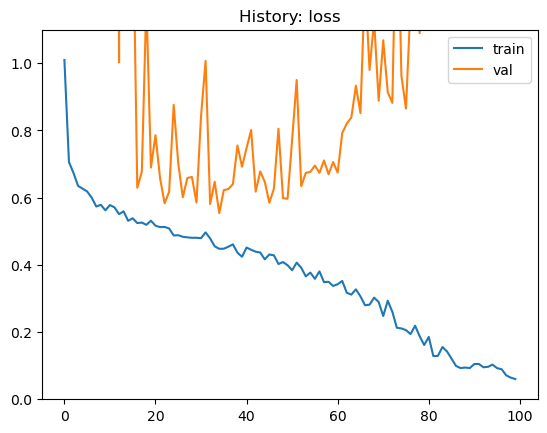

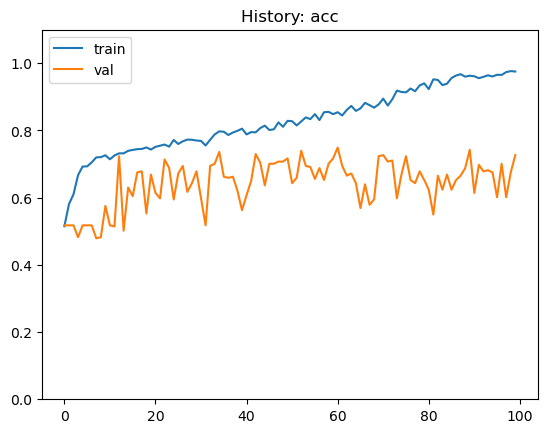

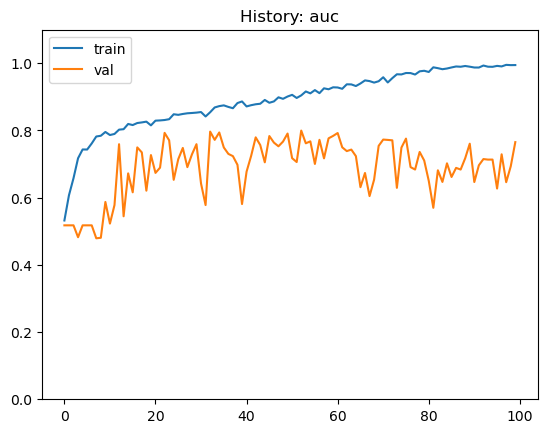

In [12]:
for m in METRICS:
    train_m = history[m]
    val_m = history['val_'+m]
    x = range(len(train_m))
    plt.title("History: " + m)
    plt.plot(x, train_m, label='train')
    plt.plot(x, val_m, label='val')
    plt.ylim((0, 1.1))
    plt.legend()
    plt.show();